This notebook can be run on Kaggle and Colab.

In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree
import jax.random as random
from jax.sharding import NamedSharding
from jax.sharding import PartitionSpec as P

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Config

feature_dim = 64
n_label = 8

EPOCHS = 10000
LEARNING_RATE = 1e-7

In [5]:
jax.devices()

E0000 00:00:1743864843.873299      11 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [6]:
mesh = jax.make_mesh((4, 2), ('a', 'b'))

x = jax.random.normal(jax.random.key(0), (8192, 8192))

z = jax.device_put(x, NamedSharding(mesh, P('a', 'b')))

print('lhs sharding:')
jax.debug.visualize_array_sharding(x)
print('rhs sharding:')
jax.debug.visualize_array_sharding(z)

w = jnp.dot(x, z)
print('out (lhs) sharding:')
jax.debug.visualize_array_sharding(w)

k = jax.device_put(x, NamedSharding(mesh, P('a', 'b')))
print('rhs:')
jax.debug.visualize_array_sharding(k)

t = jnp.dot(w, k)
print('out sharding:')
jax.debug.visualize_array_sharding(t)

lhs sharding:


                         
                         
                         
                         
                         
          TPU 0          
                         
                         
                         
                         
                         

rhs sharding:


                        
   TPU 0       TPU 1    
                        
                        
   TPU 2       TPU 3    
                        
                        
   TPU 6       TPU 7    
                        
                        
   TPU 4       TPU 5    
                        

out (lhs) sharding:


                        
                        
                        
                        
                        
TPU 0,2,4,6 TPU 1,3,5,7 
                        
                        
                        
                        
                        

rhs:


                        
   TPU 0       TPU 1    
                        
                        
   TPU 2       TPU 3    
                        
                        
   TPU 6       TPU 7    
                        
                        
   TPU 4       TPU 5    
                        

out sharding:


                        
                        
                        
                        
                        
TPU 0,2,4,6 TPU 1,3,5,7 
                        
                        
                        
                        
                        

# Prepare dataset

In [7]:
# Generate a dataset with 8000 samples 
x, y = make_classification(n_samples=8*10*100, n_features=feature_dim, n_classes=n_label, n_clusters_per_class=8, n_informative=feature_dim//8, random_state=42)

# Split the data into training and testing sets, with 20% for testing, and stratify based on the target labels
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

# Standardize the features by fitting the StandardScaler on the training set
sc = StandardScaler().fit(x_train)

# Apply the transformation to the training and test data and convert them into JAX arrays
std_x_train = jnp.array(sc.transform(x_train))
std_x_test = jnp.array(sc.transform(x_test))

# Convert the target labels into one-hot encoded vectors for both training and test sets
hot_y_train = jax.nn.one_hot(y_train, num_classes=n_label)
hot_y_test = jax.nn.one_hot(y_test, num_classes=n_label)

# Model

## Linear and MLP

In [8]:
def Linear(m, n, key):
  w_key, b_key = random.split(key)
  return { "weight": random.normal(w_key, (m, n)), "bias": random.normal(b_key, (n,)) }

def linear_forward(params, x):
  return x.dot(params["weight"]) + params["bias"]



def init_network_params(key):
  keys = random.split(key, 3)
  params = {
        "layer1": Linear(feature_dim, 8192, keys[0]),
        "layer2": Linear(8192, 8192, keys[1]),
        "layer3": Linear(8192, n_label, keys[2]),
        }
  return params

@jax.jit
def predict(params, x):
  for layer, layer_param in params.items():
    x = jax.nn.relu(linear_forward(layer_param, x))
  return x

## Funtion

In [9]:
def cross_entropy(x, t):
  return jnp.mean(-jnp.sum(t * jax.nn.log_softmax(x), axis=-1))
    
@jax.jit
def loss_fn(params, logits, target):
  return cross_entropy(predict(params, logits), target)

@jax.jit
def update(params, feature, target, learning_rate):
  grads = jax.grad(loss_fn)(params, feature, target)
  return jtree.tree_map(lambda x, y: x - (learning_rate * y), params, grads)

In [10]:
def train_loop(model, input_data, target, test_input, test_target, training_time=10000, time_per_val=100, learning_rate = 1e-9):
    history = {
        'test_loss': [],
        'epochs': []
    }

    for i in range(0, training_time):
        # Optimize model
        model = update(model, input_data, target, learning_rate)
        
        if (i+1) % time_per_val==0:
            history["test_loss"].append(loss_fn(model, test_input, test_target))
            history["epochs"].append(i)

    return model, history

# Model parallel

In [11]:
# Initialize the random number generator (PRNG) key
k = random.PRNGKey(0)
# Split the PRNG key into two parts (one for initializing the model, the other for later use)
k, sk1 = random.split(k,2)

# Initialize the model parameters
model = init_network_params(sk1)

In [12]:
# Create a mesh with 8 devices
mesh = jax.make_mesh((2,4), ('batch','model'))

def sharding(params, mesh):
    for (layer, layer_param),i in zip(params.items(),range(len(params))):
        layer_param["weight"] = jax.device_put(layer_param["weight"], NamedSharding(mesh, P(("batch", "model"))))
        layer_param["bias"] = jax.device_put(layer_param["bias"], NamedSharding(mesh, P("batch")))
    return params

In [13]:
p_model = sharding(model, mesh)

In [14]:
# Train the model using the training data, and store the training history
# The train_loop function will also return the history (e.g., losses, epochs)
p_start_time = datetime.now()
p_model, p_history = train_loop(p_model, std_x_train, hot_y_train, std_x_test, hot_y_test, training_time=EPOCHS, learning_rate=LEARNING_RATE)
p_end_time = datetime.now()

## Non-paralle version

In [15]:
# Initialize the random number generator (PRNG) key
k = random.PRNGKey(0)
# Split the PRNG key into two parts (one for initializing the model, the other for later use)
k, sk1 = random.split(k, 2)

# Initialize the model parameters
model = init_network_params(sk1)

# Move the model to the first device (usually device 0)
model_single = jax.device_put(model, jax.devices()[0])

# Train the model using the training data, and store the training history
# The train_loop function will also return the history (e.g., losses, epochs)
start_time = datetime.now()
model_single, history = train_loop(model_single, std_x_train, hot_y_train, std_x_test, hot_y_test, training_time=EPOCHS, learning_rate=LEARNING_RATE)
end_time = datetime.now()

## Comparison of training time and loss curve 

In [16]:
print(f"Execution time of Paralle : {p_end_time - p_start_time}")
print(f"Execution time of Non-Paralle : {end_time - start_time}")

Execution time of Paralle : 0:03:01.009279
Execution time of Non-Paralle : 0:08:01.073347


$ \text{SpeedUp} =  \frac{481.073347}{181.009279} \approx 2.657727546663506 $ with TPUv3-8 on Kaggle

$ \text{SpeedUp} =  \frac{1193.595985}{306.886346} \approx 3.8893746840076093 $ with TPUv2-8 on Colab

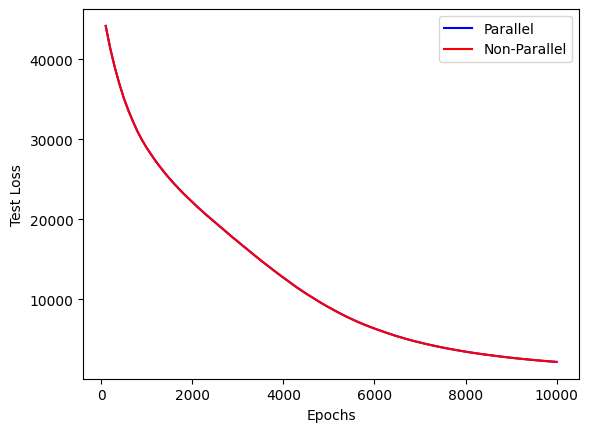

In [17]:
# Plot the test loss over the training processing
plt.plot(p_history['epochs'], p_history['test_loss'], 'b-', label='Parallel')
plt.plot(history['epochs'], history['test_loss'], 'r-', label='Non-Parallel')

plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.legend()
plt.show()